# Job shop scheduling problem

Job shop scheduling to problem, który ma wiele wariantów i wersji pochodnych, a także wiele możliwości co do optymalizacji. W moim przypadku analizujemy jedną ze standardowych wersji - mamy n maszyn, m zadań wymagających konkretnego czasu na różnych maszynach, a naszym zadaniem jest ustawienie ich w czasie aby ostateczny czas wykonania wszystkich zadań był jak najkrótszy.

In [1]:
import pygad
import random
import time

def generate_input(machine_count, job_count, random_length=False):
    re = []
    machine_count -= 1  # so there is n machines instead of n+1
    for i in range(job_count):
        job = []
        if random_length:
            length = random.randint(0, machine_count) + 1
            biggest = 0
            counter = 1
            for j in range(length):
                machine = random.randint(biggest, machine_count -
                                         length + counter)
                job.append((machine, random.randint(1, 20)))
                biggest = machine + 1
                counter += 1
        else:
            for j in range(machine_count):
                job.append((j, random.randint(1, 20)))

        re.append(job)

    return re

# input_s2 = [
#     [(0, 2), (1, 2)], job 0
#     [(0, 2), (1, 2)], job 1
#     [(0, 3), (1, 3)]  job 2
# ]

# input_s3 = [
#     [(0, 2), (1, 3)],
#     [(0, 6)],
#     [(0, 3), (1, 6)]
# ]


### Input generation

Poza małymi inputami wszystkie są generowane tą funkcją. Są one w formacie widocznym w komentarzach. O inputach więcej za chwilę.

In [2]:
def process_output(output):
    machines = [[] for i in range(MACHINE_COUNT)]
    deducted_for_idle = 0

    for i in output:
        better_i = int(i)
        job_number = str(processed_input[better_i][0])
        machine_number = processed_input[better_i][1]
        machine = machines[machine_number]
        time = processed_input[better_i][2]

        for k in range(MACHINE_COUNT):
            fill_amount = 0
            if k == machine_number:
                pass
            elif len(machines[k]) > len(machine):
                idx = len(machine)
                for j in range(time):
                    if len(machines[k]) > idx + j and machines[k][idx + j] == job_number:
                        fill_amount = j + 1

            # deduct fitness for idle time
            deducted_for_idle += fill_amount
            for j in range(fill_amount):
                machine.append('N')

        for j in range(time):
            machine.append(job_number)

    return (deducted_for_idle, machines)

### Output processing

Funkcja *process_ouptut* jest bardzo istotna. Bierze ona chromosomy i tworzy z nich rozwiązanie. Geny to liczby od 0 do n, gdzie n to liczba zadań do wykonania (małych zadań na jedną maszynę, nie całego dużego zadania z wieloma częściami do wykonania na różnych maszynach). Wybór takiego układu jest celowy, ponieważ jeżeli ustawimy, że geny nie mogą się powtarzać natychmiast eliminujemy olbrzymią liczbę rozwiązań. *process_output* iteruje po tych liczbach i ustawia odpowiednie zadanie w odpowiedniej maszynie na odpowiednią długość, wypełniając wszelkie możliwe nakładanie się tej samej pracy na dwóch maszynach pustymi polami. Po przejściu przez tą funkcję nasz wynik wygląda tak:

#### Input: 
[</br>
    &emsp;[(0, 3), (1, 2), (2, 2)],</br>
    &emsp;[(0, 2), (1, 4), (2, 1)],</br>
    &emsp;[(1, 4), (2, 3)]</br>
]

#### Output:
[2. 3. 6. 5. 0. 7. 4. 1.]

#### Processed output: 
['1', '1', '0', '0', '0']</br>
['2', '2', '2', '2', '1', '1', '1', '1', '0', '0']</br>
['0', '0', '1', 'N', '2', '2', '2']</br>
Length of all the jobs: 10

In [3]:
def fitness_func(solution, solution_idx):
    fitness = 0

    (idle, machines) = process_output(solution)

    # deduct fitness for idle time
    fitness -= idle
    # deduct a lot of fitness for the length of the entire process
    fitness -= 5 * len(max(machines, key=len))

    return fitness

### Funkcja fitness

Funkcja *process_output* jest skomplikowana, żeby funkcja fitness mogła być prosta. Odejmuje ona punkty za wszystkie puste pola i 5-krotną ilość całkowitego czasu pracy. W zadaniach laboratoryjnych zazwyczaj proste funkcje fitness były najlepsze i w tym wypadku wydaje się to sprawdzać. 

In [4]:
# 2 machines 5 jobs
input_s1 = [
    [(0, 3), (1, 3)],
    [(0, 5)],
    [(0, 2), (1, 2)],
    [(1, 5)],
    [(0, 4), (1, 3)]
]
# optimal for s1: 14

# 3 machines 3 jobs
input_s2 = [
    [(0, 53), (1, 21), (2, 34)],
    [(0, 21), (1, 71), (2, 26)],
    [(0, 42), (1, 31), (2, 12)]
]
# optimal for s2: 123

# 3 machines 3 jobs
input_s3 = [
    [(0, 3), (1, 2), (2, 2)],
    [(0, 2), (2, 1), (1, 4)],
    [(1, 4), (2, 3)]
]
# optimal for s3: 10

### Inputs

Dla małych wielkości inputów znalezienie optymalnego rozwiązania jest dość proste, nawet dla człowieka. Lecz wraz z rozmiarem szybko rośnie poziom skomplikowania i nigdy nie ma pewności czy nasze rozwiązanie rzeczywiście jest perfekcyjne. Dlatego porównywałem rozwiązania do najlepszego ze znalezionych.

### Proces

Dla ułatwienia zadania definiujemy kilka stałych, a także robimy z naszego inputu prostą listę oznaczonych małych zadań. Zaczynamy też timer, losujemy input itd. Wtedy zaczynamy proces rozwiązywania i zapisywania danych, które na koniec zapisujemy do pliku. Ponieważ dla małych inputów znaczna większość dawała idealne wyniki (a także ze względu na czas wykonywania się programu) na początek postanowiłem nie zmieniać ilości pokoleń i chromosomów dla większych danych. Dzięki temu łatwo też zobaczyć spadek dokładności w rozwiązaniach wraz ze wzrostem wielkości danych wejściowych.

In [5]:
small = [(input_s1, 2), (input_s2, 3), (input_s3, 3)]

chosen = []
results = []
times = []

for nothing in range(100):

    random_idx = random.randint(0, 2)
    CHOSEN_INPUT = small[random_idx][0]
    MACHINE_COUNT = small[random_idx][1]

    chosen.append(random_idx)

    start = time.time()
    job_count = 0
    for i in CHOSEN_INPUT:
        job_count += len(i)

    processed_input = []

    for i in range(len(CHOSEN_INPUT)):
        for j in range(len(CHOSEN_INPUT[i])):
            processed_input.append(
                (i, CHOSEN_INPUT[i][j][0], CHOSEN_INPUT[i][j][1]))

    gene_space = range(job_count)

    # ile chromsomów w populacji
    # ile genow ma chromosom
    sol_per_pop = 10
    num_genes = job_count

    # ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
    # ile pokolen
    # ilu rodzicow zachowac (kilka procent)
    num_parents_mating = 5
    num_generations = 50
    keep_parents = 1

    # jaki typ selekcji rodzicow?
    # sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
    parent_selection_type = "sss"

    # w il =u punktach robic krzyzowanie?
    crossover_type = "single_point"

    # mutacja ma dzialac na ilu procent genow?
    # trzeba pamietac ile genow ma chromosom
    mutation_type = "random"
    mutation_percent_genes = 20

    fitness_function = fitness_func

    # inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
    ga_instance = pygad.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        allow_duplicate_genes=False
    )

    # uruchomienie algorytmu
    ga_instance.run()

    end = time.time()

    # podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    # print("Parameters of the best solution : {solution}".format(solution=solution))
    # print("Fitness value of the best solution = {solution_fitness}".format(
    #     solution_fitness=solution_fitness))


    solution_vis = process_output(solution)[1]
    # print("Machine and job visualization:")
    # for i in solution_vis:
    #     print(i)

    length = len(max(solution_vis, key=len))
    # print("Length of all the jobs: {len}".format(len=length))

    # wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
    # ga_instance.plot_fitness()


    results.append(length)
    times.append(end - start)

    
with open("result.txt", "w") as f:
    f.write(str(chosen))
    f.write("\n\n")
    f.write(str(results))
    f.write("\n\n")
    f.write(str(times))

### Wyniki

Dla małych inputów 96% wyników było perfekcyjnych. Dla średnich i dużych ta liczba jest nieznana, ze względu na nieznany limit. Przeprowadziłem później testy i zwiększenie ilości chromosomów i populacji zwiększa ilość dobrych wyników, a także ich jakość.

Poniżej są wykresy znormalizowanych danych. Jak widać wyniki są bardzo różne dla większych inputów, ale jest to normalne dla zadania optymalizacyjnego z tak dużą liczbą zmiennych.

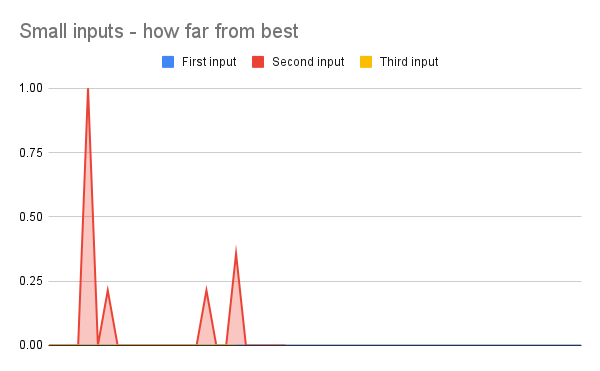 </br>
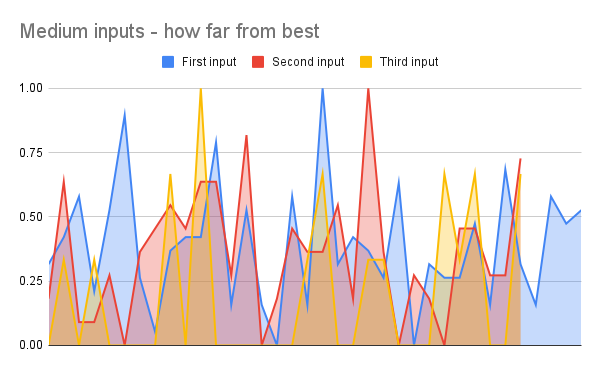 </br>
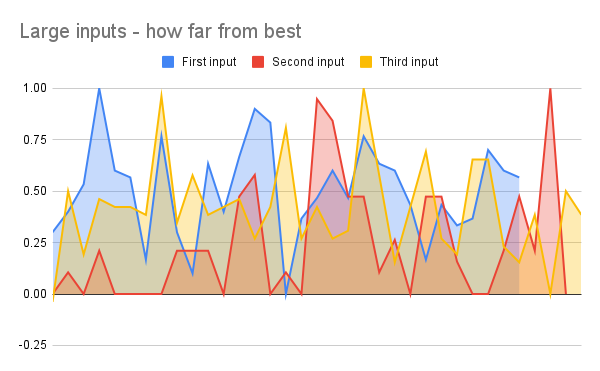 </br>

Średni czas wykonania dla, kolejno, małych, średnich i dużych inputów to: 0.094s, 1.388s, 12.637s.

Pełne dane w załączonym pliku.


## Wnioski

Zakładając adekwatną moc obliczeniową do wielkości danych algorytm genetyczny sprawdza się tutaj świetnie. Ograniczenie ilości rozwiązań dzięki braku powtórzeń jest bardzo skuteczne, mniej **możliwych** rozwiązań oznacza więcej rozwiązań sprawdzonych przez algorytm. Poza tym fakt, że funkcja fitness gwarantuje nam lepsze rozwiązanie z czasem daje nam bardzo dobre wyniki. Tutaj wyniki eksperymentu ze zwiększaniem populacji i liczby generacji dla średnich danych:

| 20 pop, 50 gen | 20 pop, 100 gen | 30 pop, 100 gen |
|----------------|-----------------|-----------------|
| 167 avg time   | 161 avg time    | 160 avg time    |

Ale co jeżeli ta ilość nie będzie jednak tak bardzo ograniczona?

## Drugi rodzaj rozwiązania

W drugim rozwiązaniu chromosomy to pary: indeks zadania i indeks maszyny. Są one ograniczone tylko od góry, mogą się powtarzać, a ich zaletą jest to, że input nie musi być zmieniany ze swojej czytelnej formy i cały proces jest trochę szybszy.

Na tym jednak zalety się kończą, ponieważ przy tej samej populacji nawet małe inputy sprawiają problemy, a średnie nie są rozwiązywane wcale. Szacuję, że pierwsze rozwiązanie odrzuca ponad 99% błędnych rozwiązań z góry, podczas gdy nowe rozwiązanie robi to dopiero w funkcji fitness. Próbowałem zwiększyć populację i liczbę pokoleń, jednak nie przyniosło to prawie żadnej poprawy.

Poniżej znajduje się nowa funkcja process_output oraz funkcja fitness. Pozostałe części programu mają tylko drobne zmiany rozrzucone po kodzie więc ich nie umieszczam.

In [6]:
def process_output(output):
    machines = [[] for i in range(MACHINE_COUNT)]
    jobs_done = []
    deducted_for_idle = 0

    for i in range(0, len(output), 2):
        job_number = int(output[i])
        machine_number = int(output[i + 1])

        if (job_number, machine_number) in jobs_done:
            return None
        elif job_number >= len(CHOSEN_INPUT):
            return None
        elif machine_number >= len(CHOSEN_INPUT[job_number]):
            return None
        else:
            job = CHOSEN_INPUT[job_number][machine_number]
            machine_number = job[0]
            machine = machines[machine_number]
            time = job[1]

        for k in range(MACHINE_COUNT):
            fill_amount = 0
            if k == machine_number:
                pass
            elif len(machines[k]) > len(machine):
                idx = len(machine)
                for j in range(time):
                    if len(machines[k]) > idx + j and machines[k][idx + j] == job_number:
                        fill_amount = j + 1

            # deduct fitness for idle time
            deducted_for_idle += fill_amount
            for j in range(fill_amount):
                machine.append('N')

        for j in range(time):
            machine.append(job_number)
        jobs_done.append((job_number, machine_number))

    return (deducted_for_idle, machines)

def fitness_func(solution, solution_idx):
    fitness = 0

    check = process_output(solution)

    if check == None:
        return -1000000
    else:
        idle = check[0]
        machines = check[1]

    # deduct fitness for idle time
    fitness -= idle
    # deduct a lot of fitness for the length of the entire process
    fitness -= 5 * len(max(machines, key=len))

    return fitness


Trochę analizy danych tego rozwiązania. Dla większych inputów niż małe nie ma rozwiązań, i wprawdzie mogę zwiększyć ilość chromosomów i pokoleń, ale to zwiększa czas wykonania, a rezultaty są znikome (nie udało mi się rozwiązać w rozsądnym czasie ani jednego średniego inputu). Dla małych 57/100 rozwiązań jest nieudana, a tylko 10/100 jest idealna. Średni czas wykonania to 0.048s, co jest szybsze niż pierwsze rozwiązanie, lecz przy wyrównaniu czasu wykonywania nie dostajemy lepszych wyników. Pełne dane poraz kolejny w pliku.

# Wniosek

Dobór chromosomów jest bardzo istotną częścią pracy z algorytmem genetycznym co pokazują moje wyniki. Pierwsze rozwiązanie skaluje się dobrze, a drugie tragicznie, właśnie z tego względu. Myślę, że gdyby przeprowadzić dłuższe testy, z większą populacją, to można by nawet znaleźć optymalne rozwiązania dla dość dużych danych, chociaż po próbach znalezienia optymalnego rozwiązania dla średnich danych dalej nie mam pewności, czy któreś z nich jest optymalne (chociaż dla 3 średniego inputu 83 wydaje się być najlepszym możliwym rozwiązaniem). 